<div class="warning" style='background-color:#15DB69; color:#000000; border-left: solid #004C23 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'>
<b>Projet Empow'her - exploration des données INSEP</b></p>
<p style='margin-left:1em;'>
Bonjour et bienvenu à cet atelier datacraft en collaboration avec l'INSEP.<br><br>
    
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'> <b>- L'équipe datacraft</b> <i>(pour l'atelier INSEP du 14 avril 2022)</i>
</p></span>
</div>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as clrs

from sklearn import preprocessing #ajout du numéro 

import time
import os

%matplotlib inline

---

Chargement des jeux de données
---

In [2]:
t_start = time.time()

df_ath1 = pd.read_pickle("/workspace/data/df_ath1_full.pkl")
df_ath2 = pd.read_pickle("/workspace/data/df_ath2_full.pkl")

df_morning_ath1 = pd.read_pickle("/workspace/data/df_ath1_morning.pkl")
df_morning_ath2 = pd.read_pickle("/workspace/data/df_ath2_morning.pkl")

print(f"Time taken: {time.time()-t_start}")

Time taken: 1.4734795093536377


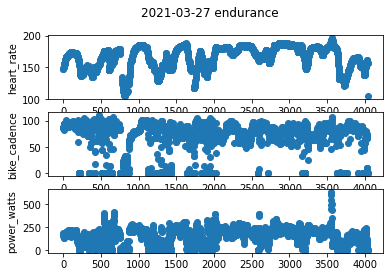

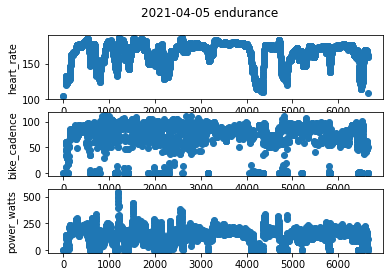

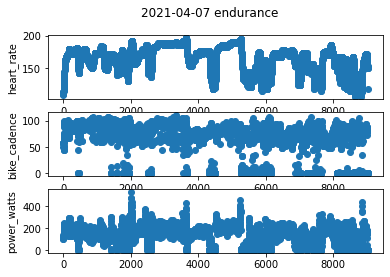

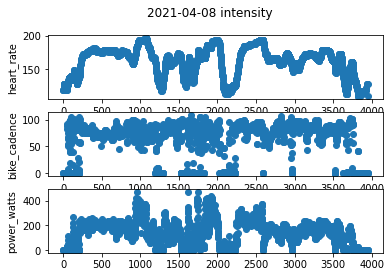

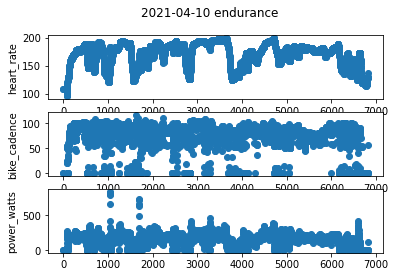

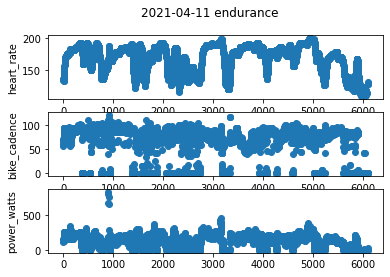

In [3]:
features = ["heart_rate", "bike_cadence", "power_watts"]#, "altitude", "temperature"]

_,indexes,lengths = np.unique(df_ath1.training_counter,return_counts=True,return_index=True)
for i in range(6):#range(len(lengths)-1):
    training = df_ath1.loc[indexes[i]:indexes[i+1]]
    if len(training):

        fig, axs = plt.subplots(len(features),1)
        axs = axs.flatten()

        for feature,ax in zip(features,axs):
            ax.scatter(range(len(training)),training[feature])
            ax.set_ylabel(feature)
        plt.suptitle(str(training.date.iloc[0]) + ' ' + training.type_ent.iloc[0])

In [ ]:
# utilisation des 20 premiers entrainement d'endurance
#

# Train HMM over first endurance trainings

In [4]:
from hmmlearn.hmm import GaussianHMM


In [5]:
# Train set has 10 first endurance trainings
%run utils.ipynb

n_train_series = 20

endurance_ath1 = filter_df(df_ath1, qtty='type_ent', filtre={'kind':'include', 'list':["endurance"]}).sort_values(by='training_counter')
_,indexes,lengths = np.unique(df_ath1.training_counter,return_counts=True,return_index=True)

train_ath1 = endurance_ath1[:indexes[n_train_series]]
np.unique(train_ath1.training_counter)

array([ 1,  2,  3,  5,  6,  8,  9, 10, 11, 13, 14, 16, 18, 19, 20, 21, 22,
       29])

In [6]:
# fill missing points with interpolation (daily series)
train_ath1_interp = train_ath1.copy()
for training_counter in np.unique(train_ath1.training_counter):
    training = train_ath1[train_ath1.training_counter==training_counter]
    train_ath1_interp.loc[train_ath1_interp.training_counter==training_counter,features] = training[features].interpolate(method ='linear', limit_direction ='backward', inplace=False)
len(train_ath1_interp),indexes[n_train_series], len(np.unique(train_ath1_interp.training_counter))

(140863, 140863, 18)

In [7]:
# training with training_counter==21 has NaN
train_ath1_interp.dropna(inplace=True)
np.unique(train_ath1.training_counter)
_,indexes,lengths = np.unique(train_ath1_interp.training_counter,return_counts=True,return_index=True)

In [8]:
# train models with 2 or 3 hidden states
n_states =3
features = ["heart_rate", "bike_cadence", "power_watts"]#, "altitude", "temperature"]

model_2states=GaussianHMM(n_components=2, algorithm='viterbi',covariance_type='full')
model_2states.fit(train_ath1_interp[features],lengths[:n_train_series])

model_3states=GaussianHMM(n_components=3, algorithm='viterbi',covariance_type='full')
model_3states.fit(train_ath1_interp[features],lengths[:n_train_series])

GaussianHMM(covariance_type='full', n_components=3)

In [9]:
def plot_hidden_states(data,model,features):
    predictedStates = model.predict(data[features])
    
    fig, axs = plt.subplots(len(features),1,figsize=(10,5))
    axs = axs.flatten()

    for feature,ax in zip(features,axs):
        ax.scatter(range(len(data)),data[feature],c=predictedStates, alpha=0.5)
        ax.set_ylabel(feature)
    plt.suptitle(str(data.date.iloc[0]) + ' ' + data.type_ent.iloc[0])
    
    fig, axs = plt.subplots(1,len(features),figsize=(10,4))
    axs = axs.flatten()
    axs[0].scatter(data[features[0]],data[features[1]],c=predictedStates, alpha=0.5)
    axs[0].set_xlabel(features[0])
    axs[0].set_ylabel(features[1])
    axs[1].scatter(data[features[0]],data[features[2]],c=predictedStates, alpha=0.5)
    axs[1].set_xlabel(features[0])
    axs[1].set_ylabel(features[2])
    axs[2].scatter(data[features[1]],data[features[2]],c=predictedStates, alpha=0.5)
    axs[2].set_xlabel(features[1])
    axs[2].set_ylabel(features[2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


training_counter  score_2states  score_3states
0                1.0  -54036.712323  -50763.393588
1                2.0  -86824.048930  -81540.345714
2                3.0 -121633.505413 -111190.126718
3                5.0  -92630.808436  -87159.888552
4                6.0  -83264.004296  -76358.768464
5                8.0 -130853.399270 -118017.681444
6                9.0  -68984.141938  -65001.124139
7               10.0 -212539.466670 -198118.065316
8               11.0  -95136.000550  -88161.835143
9               13.0 -136076.810805 -124886.302443
10              14.0 -131340.550483 -116385.135983
11              16.0 -100047.775790  -92927.638245
12              18.0 -131872.711032 -119918.910968
13              19.0  -89844.101985  -84395.639516
14              20.0  -14630.681797  -13622.544616
15              21.0  -31250.894629  -29241.659373
16              22.0  -90162.705365  -85987.213644
17              29.0 -135617.696270 -128261.092029

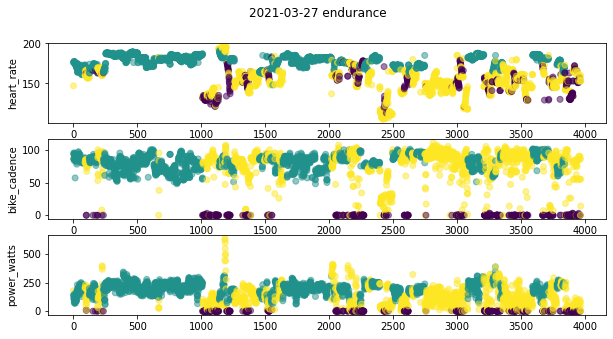

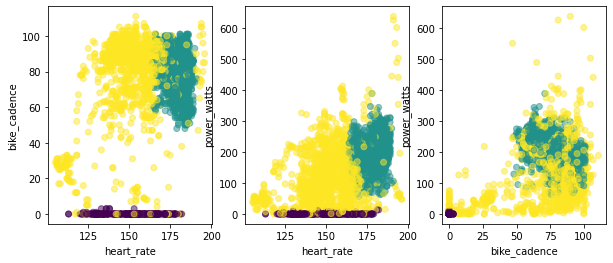

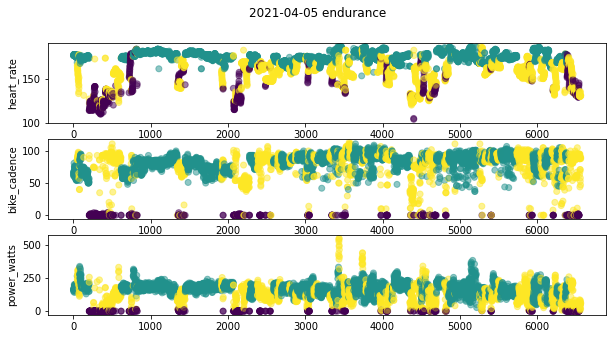

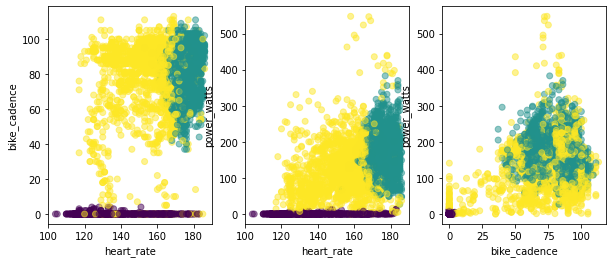

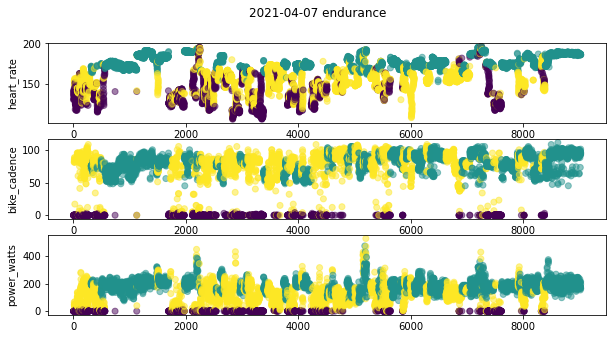

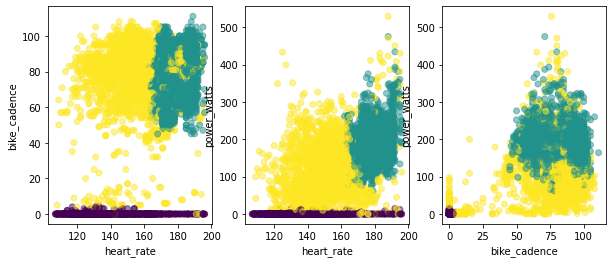

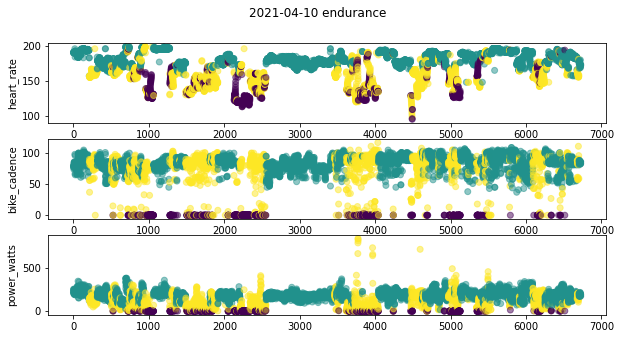

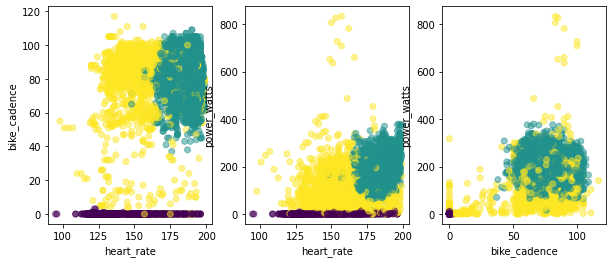

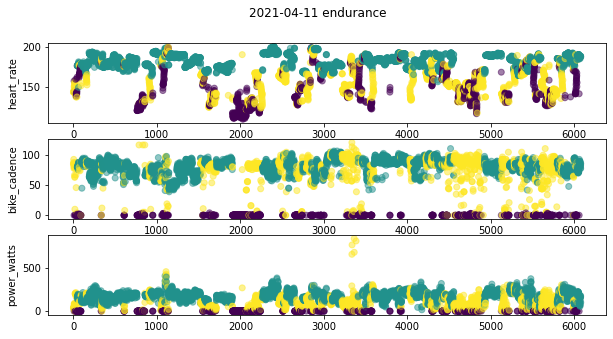

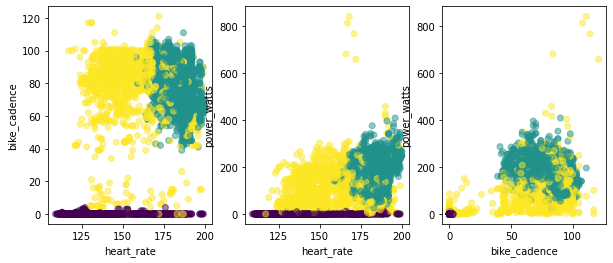

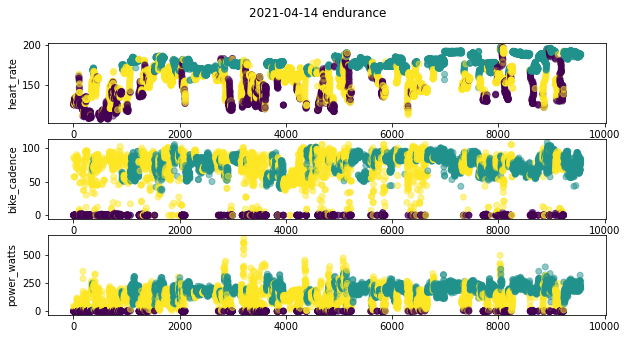

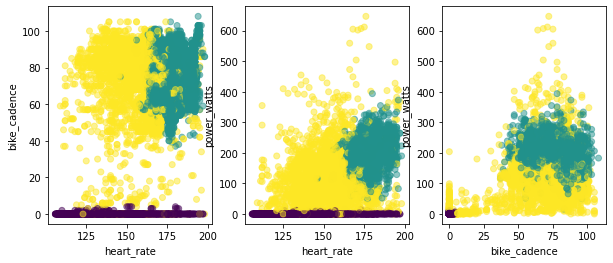

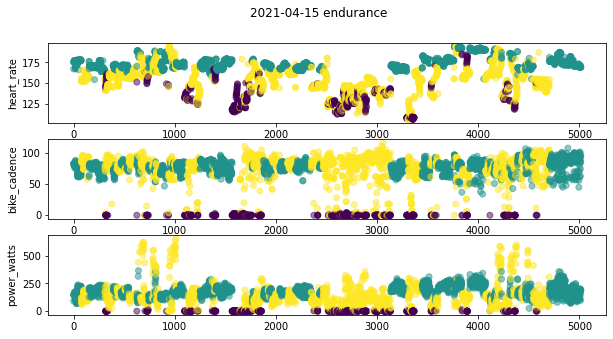

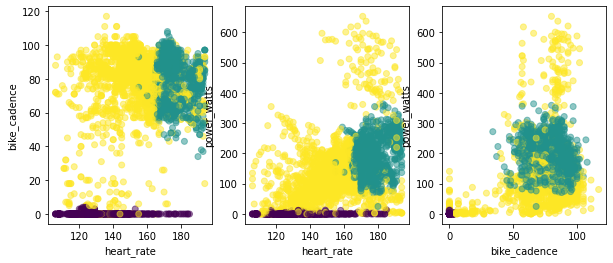

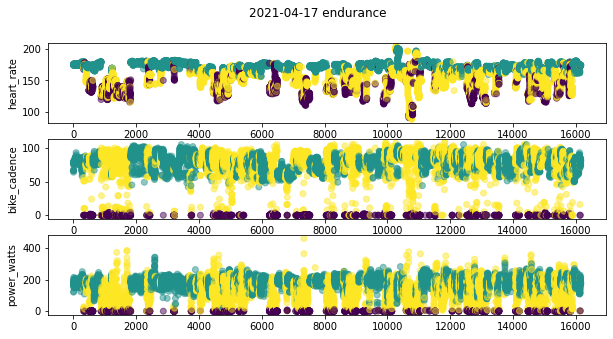

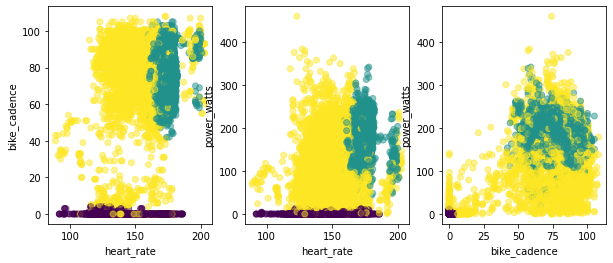

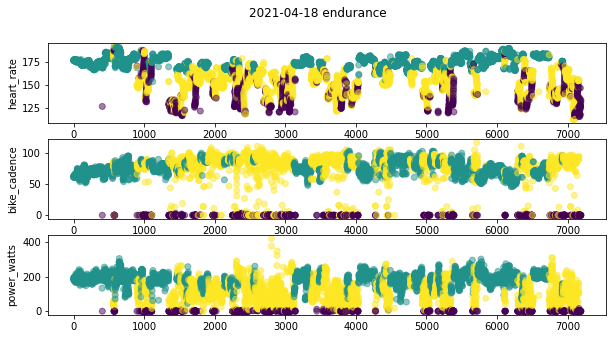

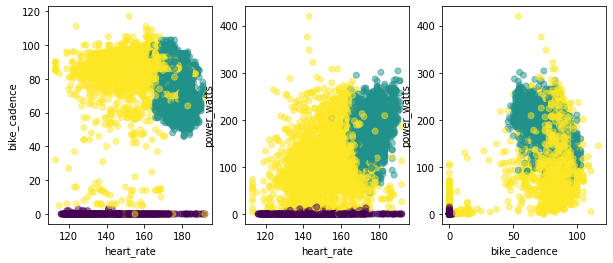

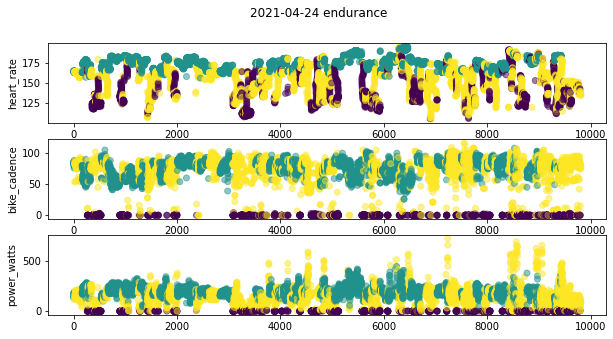

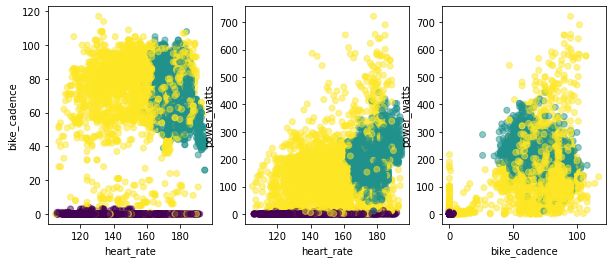

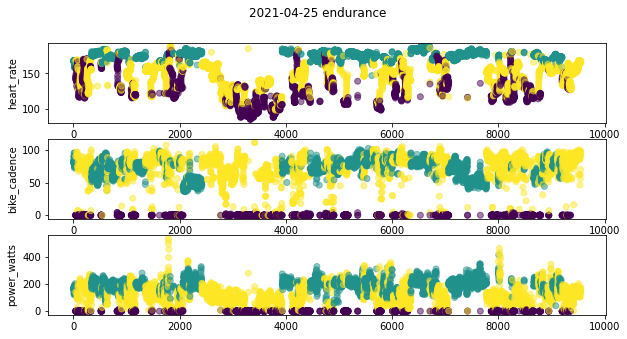

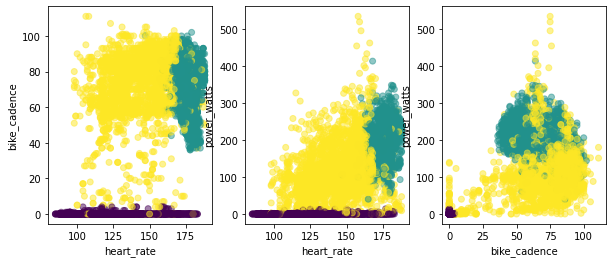

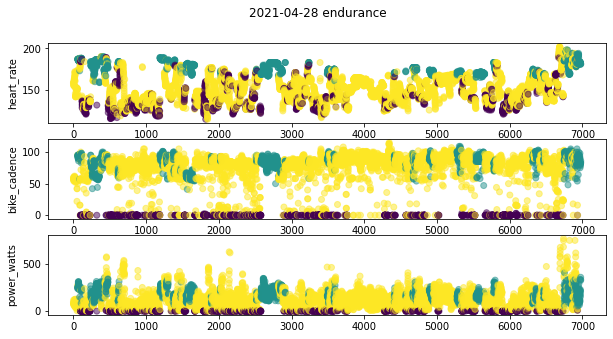

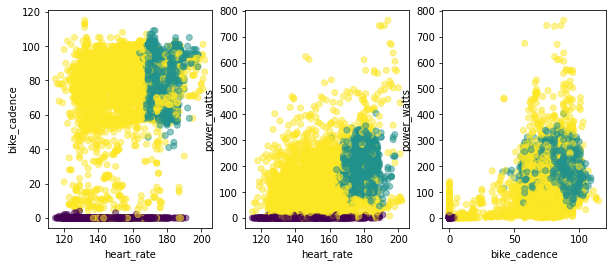

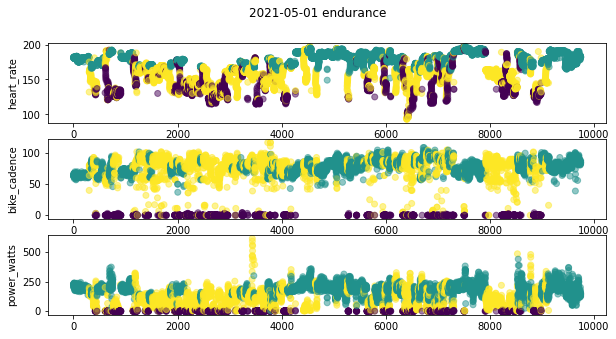

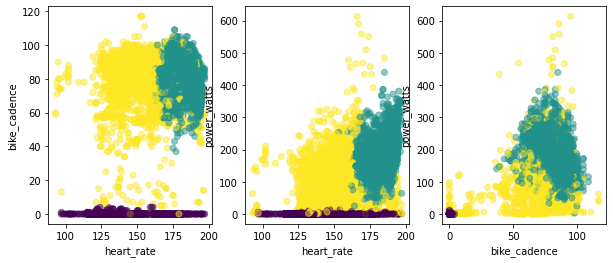

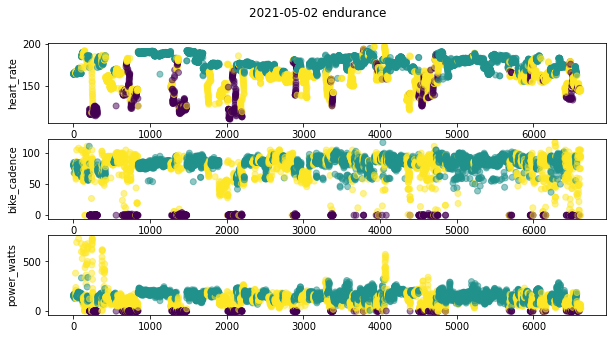

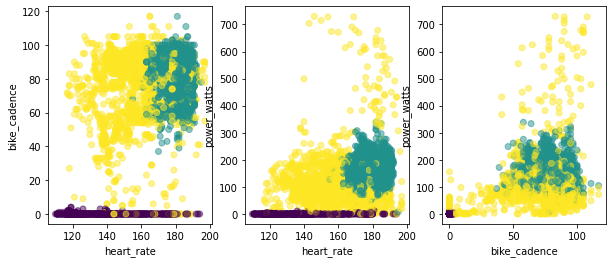

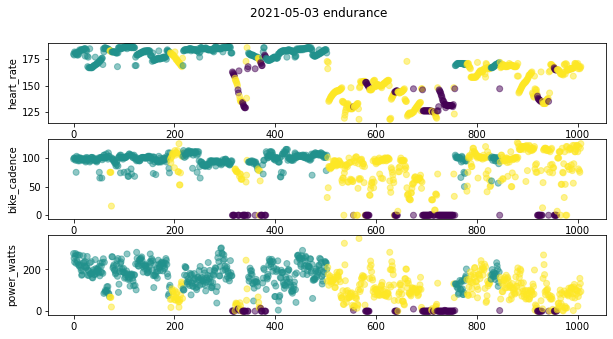

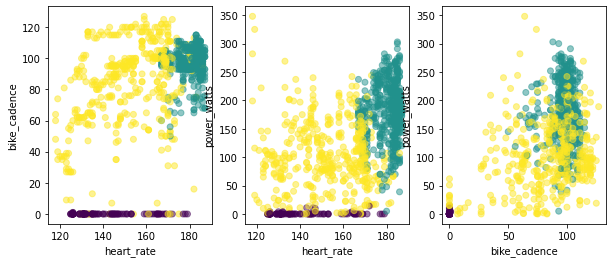

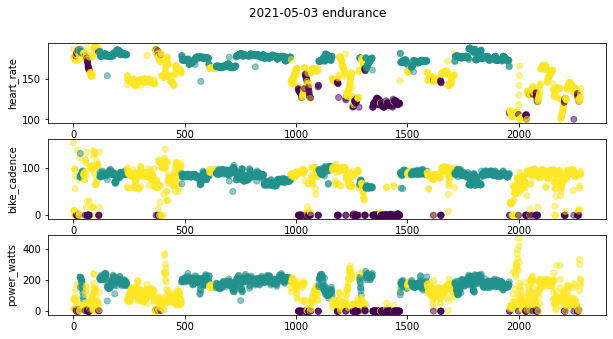

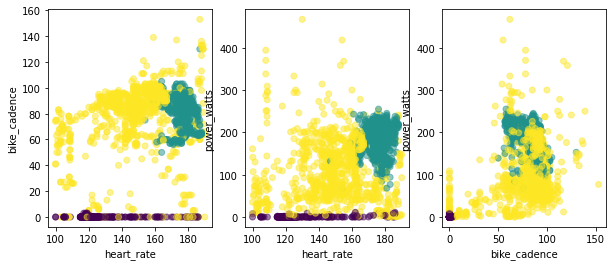

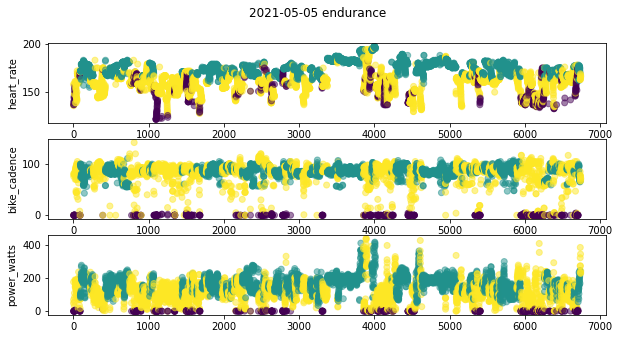

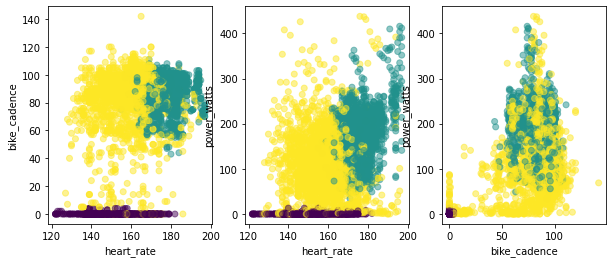

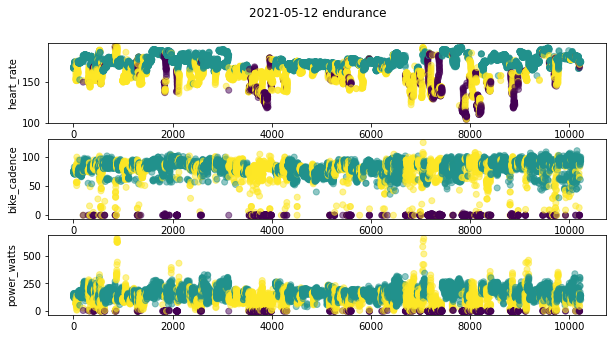

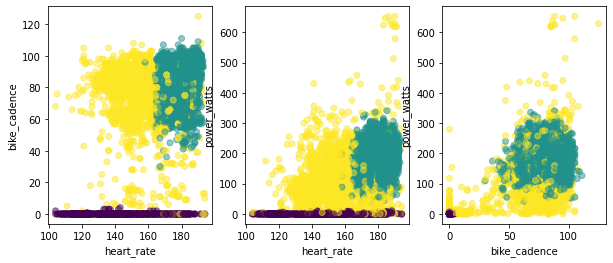

In [10]:
# predict hidden states and plot series. Estimate scores for train days
train_ath1_interp['predictedStates'] = model_3states.predict(train_ath1_interp[features],lengths[:n_train_series])
scores = pd.DataFrame(columns=['training_counter','score_2states','score_3states'])
for training_counter in np.unique(train_ath1.training_counter):
    training = train_ath1_interp[train_ath1_interp.training_counter==training_counter]
    
    # training score
    predictedScore_2states = model_2states.score(training[features])
    predictedScore_3states = model_3states.score(training[features])
    scores = scores.append({'training_counter':training_counter,'score_2states':predictedScore_2states,'score_3states':predictedScore_3states},ignore_index=True)

    plot_hidden_states(training,model_3states,features)
    
scores    

# Test set

In [11]:
not_endurance = filter_df(df_ath1, qtty='type_ent', filtre={'kind':'exclude', 'list':["endurance"]}).sort_values(by='training_counter')
# _,indexes,lengths = np.unique(not_endurance.training_counter,return_counts=True,return_index=True)
# indexes

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

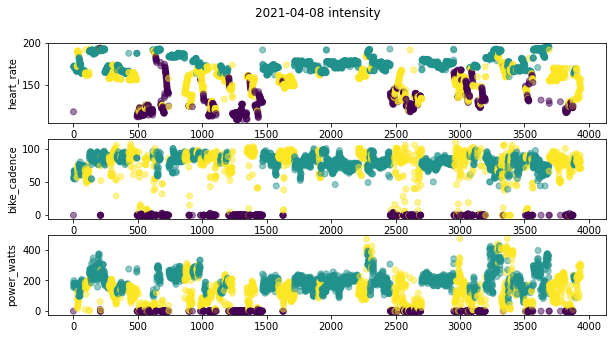

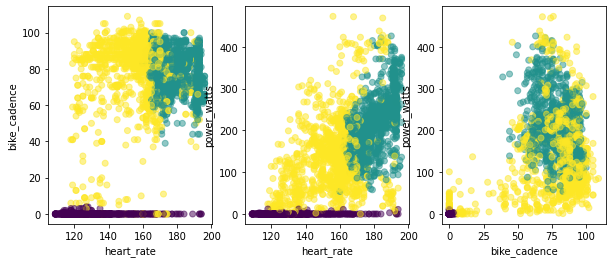

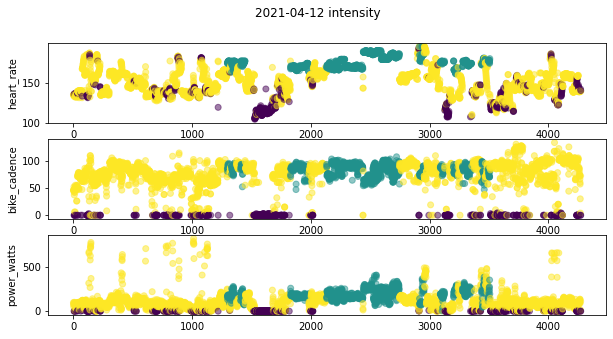

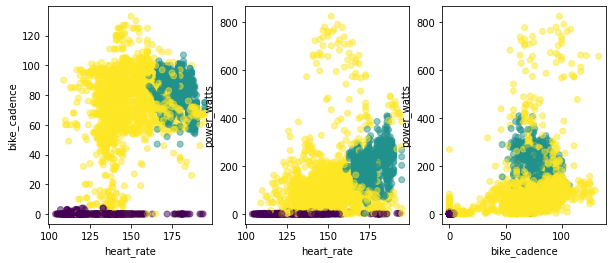

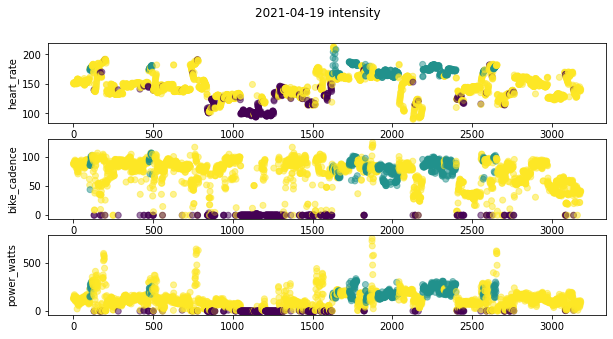

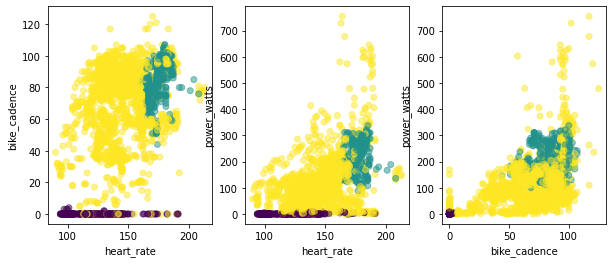

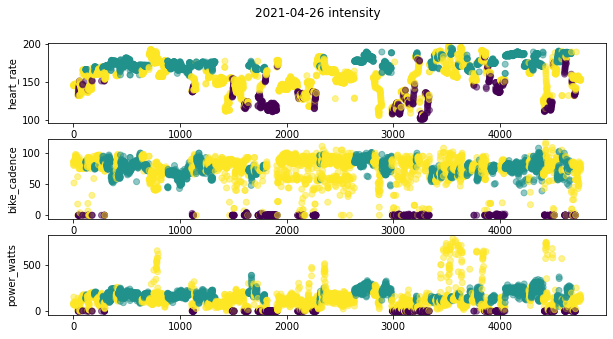

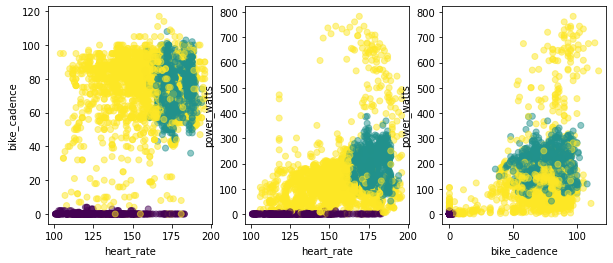

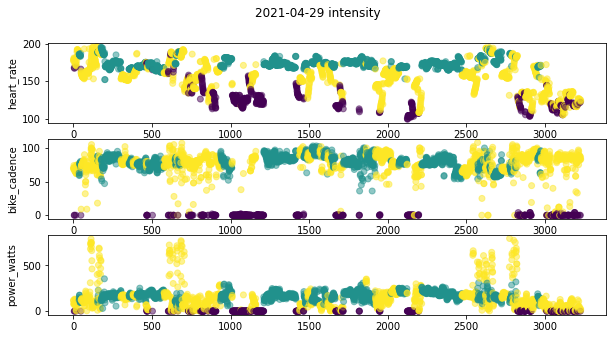

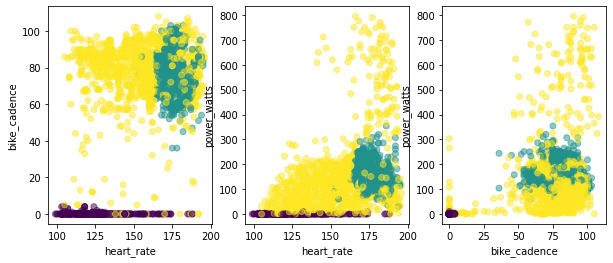

In [20]:
test_scores = pd.DataFrame(columns=['training_counter','score_2states','score_3states'])
for training_counter in np.unique(not_endurance.training_counter)[:6]:
    training = not_endurance[not_endurance.training_counter==training_counter]
    training_interp = training.copy()
    training_interp[features] = training[features].interpolate(method ='linear', limit_direction ='backward', inplace=False)
    training_interp = training_interp.dropna()
    
    # training score
    predictedScore_2states = model_2states.score(training_interp[features])
    predictedScore_3states = model_3states.score(training_interp[features])
    test_scores = test_scores.append({'training_counter':training_counter,'score_2states':predictedScore_2states,'score_3states':predictedScore_3states},ignore_index=True)
    
    plot_hidden_states(training_interp,model_3states,features)
    
test_scores

In [ ]:
# histogramme = log-probabilité pour les 20 entrainements 


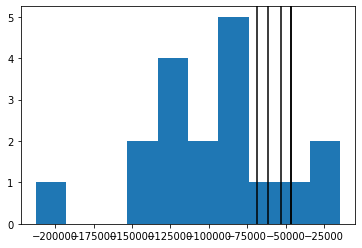

In [16]:
plt.hist(scores.score_2states)
for val in test_scores.score_2states:
    plt.axvline(val,color='k')


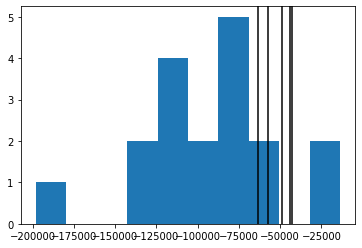

In [17]:
plt.hist(scores.score_3states)
for val in test_scores.score_3states:
    plt.axvline(val,color='k')

In [18]:
_,indexes,lengths = np.unique(endurance_ath1.training_counter,return_counts=True,return_index=True)
test_endurance = endurance_ath1[indexes[n_train_series]:]
np.unique(test_endurance.training_counter)


array([ 32,  33,  34,  36,  38,  39,  42,  44,  53,  61,  66,  68,  69,
        72,  73,  81,  82,  87,  89,  90,  98,  99, 100, 101, 102, 104,
       105, 107, 108, 109, 114, 116, 117, 123, 124, 125, 126, 128, 129,
       130, 131, 132, 133, 135, 136, 137, 139, 141, 142, 143, 145, 146,
       147])

training_counter  score_2states  score_3states
0              33.0 -202903.325414 -188751.924740
1              34.0 -192838.127718 -177179.491964
2              36.0 -133134.480881 -124862.431886
3              38.0 -125164.364038 -117506.591027
4              39.0  -91505.471559  -85832.631877
5              42.0 -125910.504289 -116276.906400
6              44.0 -133744.523227 -123157.785804
7              53.0 -220174.991246 -202910.667919
8              61.0 -110943.626551 -101882.961289

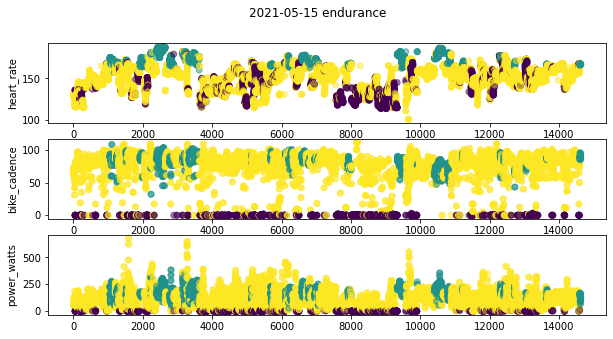

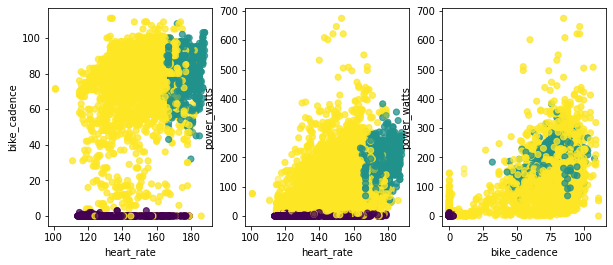

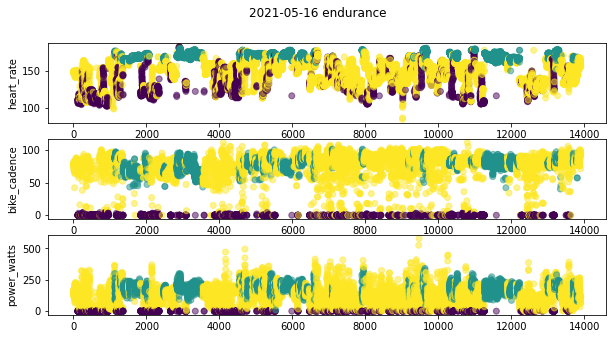

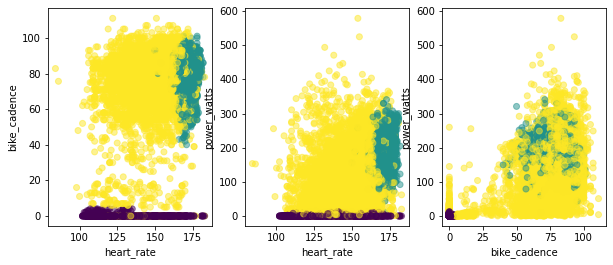

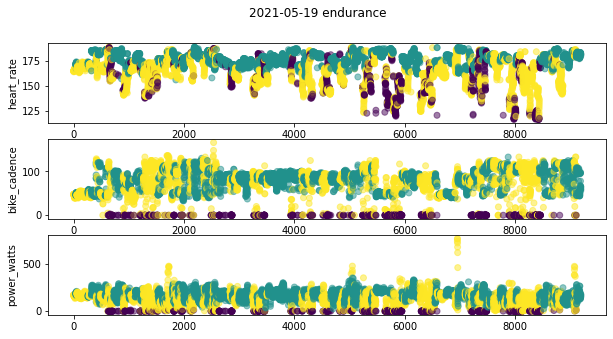

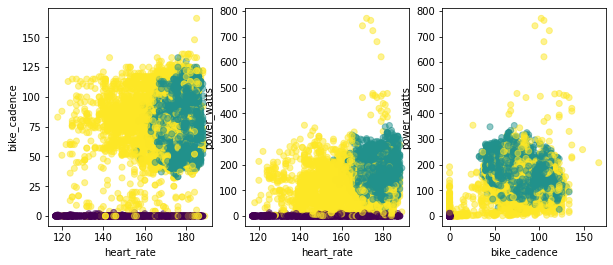

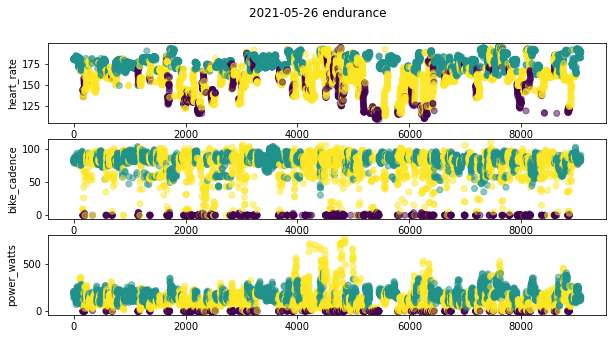

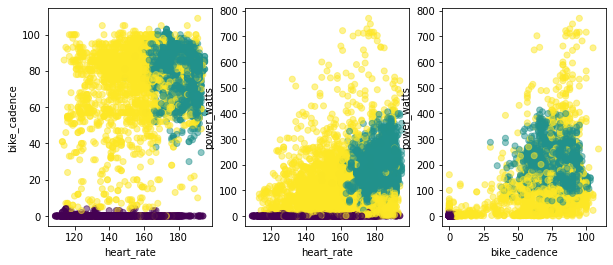

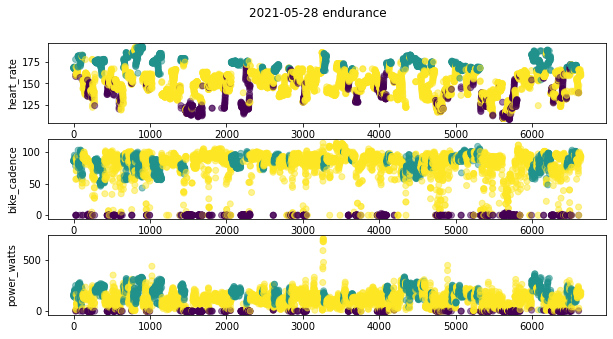

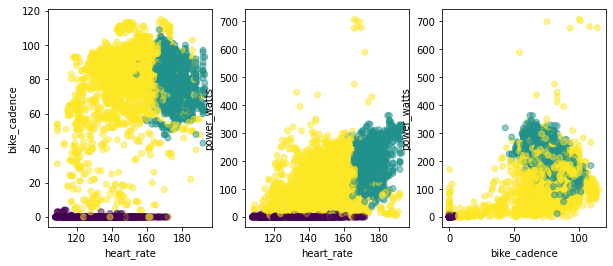

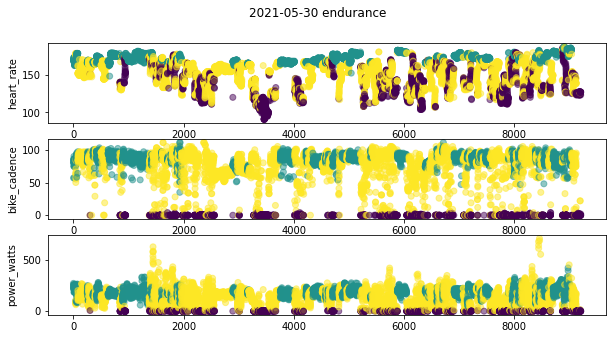

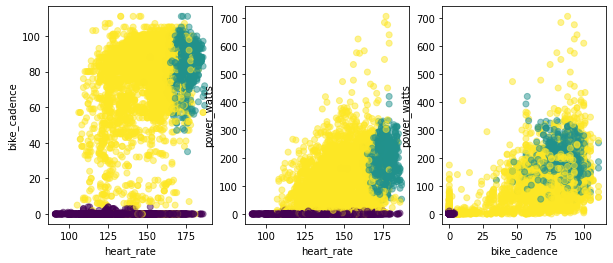

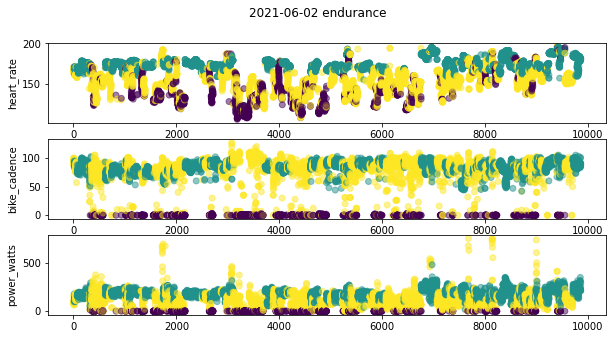

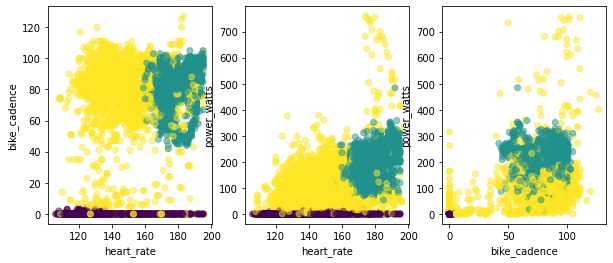

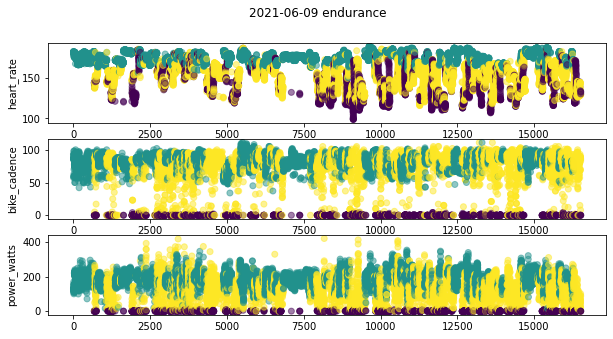

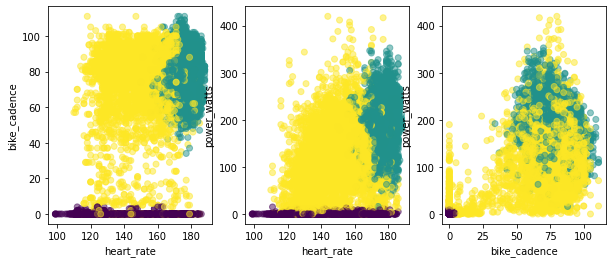

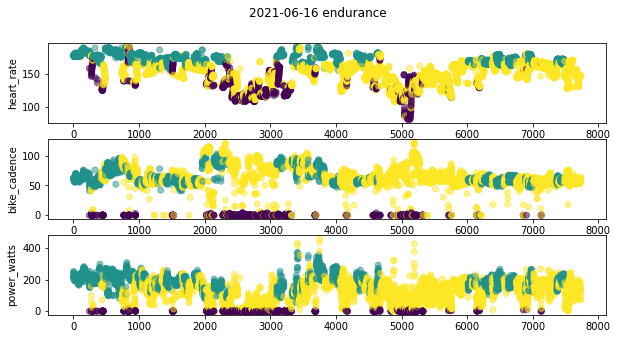

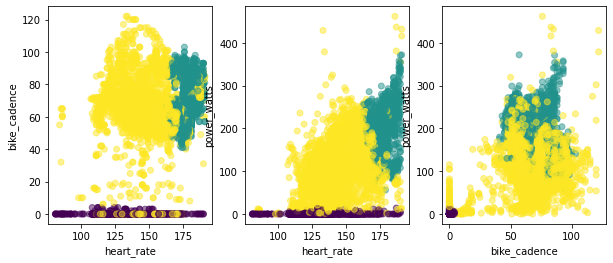

In [22]:
test_scores = pd.DataFrame(columns=['training_counter','score_2states','score_3states'])
for training_counter in np.unique(test_endurance.training_counter)[:10]:
    training = test_endurance[test_endurance.training_counter==training_counter]
    training_interp = training.copy()
    training_interp[features] = training[features].interpolate(method ='linear', limit_direction ='backward', inplace=False)
    training_interp = training_interp.dropna()
    
    if len(training_interp)<2:
        continue
    
    # training score
    predictedScore_2states = model_2states.score(training_interp[features])
    predictedScore_3states = model_3states.score(training_interp[features])
    test_scores = test_scores.append({'training_counter':training_counter,'score_2states':predictedScore_2states,'score_3states':predictedScore_3states},ignore_index=True)
    
    plot_hidden_states(training_interp,model_3states,features)
test_scores

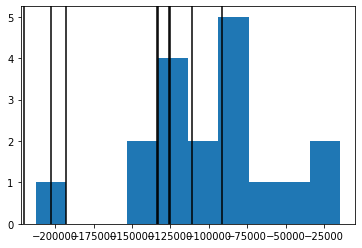

In [23]:
plt.hist(scores.score_2states)
for val in test_scores.score_2states:
    plt.axvline(val,color='k')

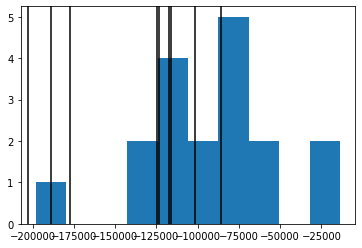

In [24]:
plt.hist(scores.score_3states)
for val in test_scores.score_3states:
    plt.axvline(val,color='k')